<img src="./img/HWNI_logo.svg"/>

# Lab 06a - Linear Algebra

In [2]:
# makes our plots show up inside Jupyter
%matplotlib notebook

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

# choose colors that work for most color-blind folks
sns.set_palette("colorblind")
sns.set(color_codes=True)

import time

import util.lab06utils as utils 

# this makes our tables easier to read
utils.formatDataframes()

In [29]:
import cmath

def makeMesh(meshProps):
    numDimensions = 2
    
    mins = (meshProps['xMin'],meshProps['yMin'])
    maxs = (meshProps['xMax'],meshProps['yMax'])
    delta = meshProps['delta']
    
    for idx in range(numDimensions):
        assert mins[idx] < maxs[idx], "min can't be bigger than max!"
        
    ranges = [np.arange(mins[idx],maxs[idx]+delta,delta) for idx in range(numDimensions)]
    
    xs,ys = np.meshgrid(*ranges)
    
    return xs,ys

def plotMesh(f,ax,xs,ys,colors):
    ax.set_aspect('equal')
    h = plt.scatter(xs,ys,
                facecolor='black',alpha=0.7,
                    edgecolor='none',
                s=36,linewidth=2,
                zorder=6,
               c=colors,cmap='hot')
    
    return h

def plotVector(v,color,label=None):
    return plt.arrow(0,0,v[0],v[1],zorder=5,
              linewidth=6,color=color,head_width=0.1,label=label)
    
    
def plotInterestingVectors(T,columns=False,eigs=True):
    arrows = []
    labels = []
    if columns:
        arrows += [plotVector(column,'hotpink') 
                       for column in T.T]
        arrows = [arrows[0]]
        labels += ["a basis vector lands here"]
    if eigs:
        eigenvalues,eigenvectors = np.linalg.eig(T)
        eigenList = [(eigenvalue,eigenvector) for eigenvalue,eigenvector
                                    in zip(eigenvalues,eigenvectors.T)
                                  if eigenvalue != 0
                                      and not(np.iscomplex(eigenvalue))
                                      ]
        if eigenList:
            eigenArrows = [plotVector(np.real(element[1]),'#53fca1',label='special vectors')
                                 for element
                                     in eigenList
                                     ]
            eigenArrows = [eigenArrows[0]]
            labels += ["this is a special (aka eigen) vector"]
            arrows += eigenArrows
        else:
            print("eigenvalues are all nonreal or 0")
    plt.legend(arrows,labels,loc=[0,0.5],
               bbox_to_anchor=(0,1.05),
              ncol=2,prop={'weight':'bold'})
    return

def computeTrajectories(T,scatter):
    
    starting_positions = scatter.get_offsets()
    ending_positions = np.dot(T,starting_positions.T).T
    delta_positions = ending_positions-starting_positions
    
    return starting_positions,ending_positions,delta_positions

def setAxesLims(mn,mx,ax=None):
    if ax == None:
        ax = plt.gca()

    ax.set_ylim([mn,mx])
    ax.set_xlim([mn,mx])
    
    return

def calculateAxisBounds(starting_positions,ending_positions,bufferFactor=1.1):
    #axis bounds to include starting and ending positions of each point
    
    mn = bufferFactor*min(np.min(starting_positions),np.min(ending_positions))
    mx = bufferFactor*max(np.max(starting_positions),np.max(ending_positions))
    
    if mn == 0:
        mn -= 0.1
    if mx == 0:
        mx += 0.1
        
    return mn,mx

def drawCoordinateAxes(mn,mx,ax=None):
    if ax == None:
        ax = plt.gca()
    plt.hlines(0,mn,mx,zorder=4,linewidth=4,color='grey')
    plt.vlines(0,mn,mx,zorder=4,linewidth=4,color='grey')
    
    return

def makeRotation(theta):
    rotationMatrix = [[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]]
    return np.asarray(rotationMatrix)

In [7]:
unitSquareMesh = {'delta':0.1,
                    'xMin' :0,
                    'xMax' : 1,
                    'yMin' : 0,
                    'yMax' : 1,}

foursquareMesh = {'delta':0.1,
                    'xMin' :-0.5,
                    'xMax' : 0.5,
                    'yMin' : -0.5,
                    'yMax' : 0.5,}

def setupPlot(T,meshProperties=unitSquareMesh,squareAxes=False,
             plotColumns=False,plotEigenvectors=False):
    """
    Setup the plot and axes for animating a linear transformation T.
    
    If asked, plot the columns (aka the images of the basis vectors)
        and the eigenvectors (but only if they're real and non-zero).
    
    Parameters
    ----------
    T        : 2x2 matrix representing a linear transformation
    meshProperties : dictionary that defines properties of meshgrid of points
                        that will be plotted and transformed.
                        needs to have the following five properties:
                        'delta' - mesh spacing
                        '{x,y}{Min,Max}' - minium/maximum value on x/y axis
    squareAxes : if False, size the axes so that they contain starting
                    and ending location of each point in grid.
                 if True, size the axes so that they are square and contain
                    starting and ending location of each point in mesh.
    plotColumns : if True, plot the columns of the transformation so that we can see
                        where the basis vectors end up
    plotEigenvectors: if true, plot the eigenvectors of the transformation
    
    Returns
    -------
    returns are meant to be consumed by animateTransformation
    
    scatter   : a PathCollection with all of the points in the meshgrid
    f         : matplotlib figure containing axes
    ax        : matplotlib axes containing scatter
    """
    T = np.asarray(T)
    
    xs,ys = makeMesh(meshProperties)
    colors = np.linspace(0,1,num=xs.shape[0]*xs.shape[1])
    
    f = plt.figure(figsize=(6,6))
    ax = plt.gca()
    
    scatter = plotMesh(f,ax,xs,ys,colors)
    
    plotVectors = [plotColumns,plotEigenvectors]
    
    notZeros = not(np.all(T == np.zeros(2)))
    
    if (any(plotVectors) & notZeros):
        plotInterestingVectors(T,*plotVectors)
    
    start,end,delta = computeTrajectories(T,scatter)
    
    mn,mx = calculateAxisBounds(start,end)
    
    if squareAxes:
        lim = max(abs(mn),abs(mx))
        mn = -lim; mx = lim
    
    drawCoordinateAxes(mn,mx)
    setAxesLims(mn,mx,ax=ax)

    f.canvas.draw()
    time.sleep(1)
    
    return scatter,f,ax
    

def animateTransformation(T,scatter,figure,
                          meshProperties=unitSquareMesh,
                          deltaT=0.05,delay=0.,):
    """
    Animate a linear transformation T acting on points scatter in figure.
    
    If asked, plot the columns (aka the images of the basis vectors)
        and the eigenvectors (but only if they're real and non-zero).
    
    Parameters
    ----------
    T        : 2x2 matrix representing a linear transformation
    meshProperties : dictionary that defines properties of meshgrid of points
                        that will be plotted and transformed.
                        needs to have the following five properties:
                        'delta' - mesh spacing
                        '{x,y}{Min,Max}' - minium/maximum value on x/y axis
    deltaT   : size of simulated timestep -- transformation complete at t = 1
    delay    : if non-zero, python will pause between frames of the animation for
                that many seconds.
    
    Returns
    -------
    returns are meant to be consumed by animateTransformation
    
    scatter   : a PathCollection with all of the points in the meshgrid
    f         : matplotlib figure containing axes
    ax        : matplotlib axes containing scatter
    """

    
    T = np.asarray(T)
    
    start,_,delta = computeTrajectories(T,scatter)
    
    I = np.eye(2)
    
    ts = np.arange(0,1+deltaT,deltaT)
    
    notZeros = not(np.all(T == np.zeros(2)))
    
    if ((T[0,0] == T[1,1]) & (T[0,1] == -1*T[1,0])) & \
            notZeros :
        
        z = complex(T[0,0],T[1,0])
        dz = z**(1/len(ts))
        
        dT = [[dz.real,-dz.imag],[dz.imag,dz.real]]
        for idx,t in enumerate(ts):
            current_positions = scatter.get_offsets()
            dT_toN = np.linalg.matrix_power(dT,idx+1)
            scatter.set_offsets(np.dot(dT_toN,start.T).T)
            figure.canvas.draw()
            if delay:
                time.sleep(delay)
                
    else:
        for idx,t in enumerate(ts):
            current_positions = scatter.get_offsets()
            scatter.set_offsets(t*(np.dot(T,start.T).T) +
                                   (1-t)*np.dot(I,start.T).T)

            figure.canvas.draw()
            if delay:
                time.sleep(delay)

In [12]:
scaling = [[3,0],[0,3]]
shear = [[1,2],[0,0.5]]

reflection = [[0,1],[1,0]]

rank0 = [[0,0],[0,0]]
rank1 = [[1,2],[1,2]]

R = makeRotation(theta=np.pi/2)

T = np.asarray([[1,3],
                [0,1]])

In [13]:
R

array([[  6.12323400e-17,  -1.00000000e+00],
       [  1.00000000e+00,   6.12323400e-17]])

In [26]:
transform = np.dot(R,np.diag([2,2]))
transform = rank1
transform = T

transform = np.dot(scaling,R)

mesh = unitSquareMesh

<IPython.core.display.Javascript object>


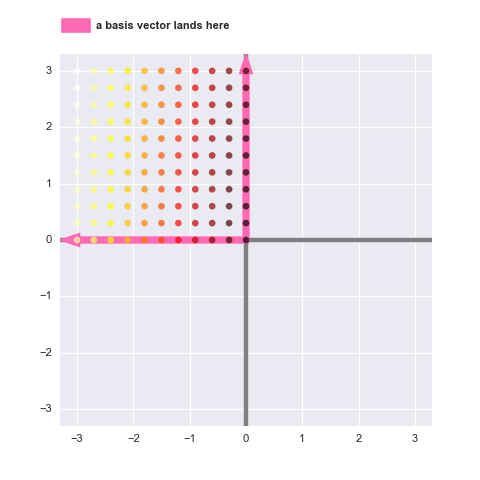

eigenvalues are all nonreal or 0


In [28]:
scatter,figure,axes = setupPlot(transform,
                                meshProperties=mesh,
                                plotColumns=True,
                                plotEigenvectors=True)

animateTransformation(transform,scatter,figure,
                                meshProperties=mesh,
                                 delay=0.05)

Begin by examining the following linear transformations:

#### Q3 What's a CDF again? Why do we use the CDF of the sampling distribution of the statistic to compute p-values?